# Facebook's prophet for time series forecasting

**Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import datetime
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False


In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')

In [4]:
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeStamp  49205 non-null  object 
 1   demand     49124 non-null  float64
 2   precip     48975 non-null  float64
 3   temp       49019 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [6]:
df['timeStamp']=pd.to_datetime(df['timeStamp'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [8]:
fig=px.line(df,x='timeStamp',y='demand',title='Energy consumption')

fig.update_xaxes(
    rangeslider_visible= True,
    rangeselector=dict(
                        buttons = list([
                        dict(count = 1,label = '1m',step='month',stepmode = "backward"),
                        dict(count = 2,label = '6m',step='month',stepmode = "backward"),
                        dict(count = 3,label = '6mYTD',step='month',stepmode = "todate"),
                        dict(count = 4,label = '2y',step='year',stepmode = "backward"),
                        dict(count = 5,label = '3y',step='year',stepmode = "backward"),
                        dict(step= 'all')
                            ])        
                        )
                   )
fig.show()

In [9]:
ny_df=df.set_index('timeStamp')

In [10]:
ny_df.head()

,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,4752.1,0.0,45.89
2012-01-01 02:00:00,4542.6,0.0,45.04
2012-01-01 03:00:00,4357.7,0.0,45.03
2012-01-01 04:00:00,4275.5,0.0,42.61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f31e13840d0>,
      dtype=object)

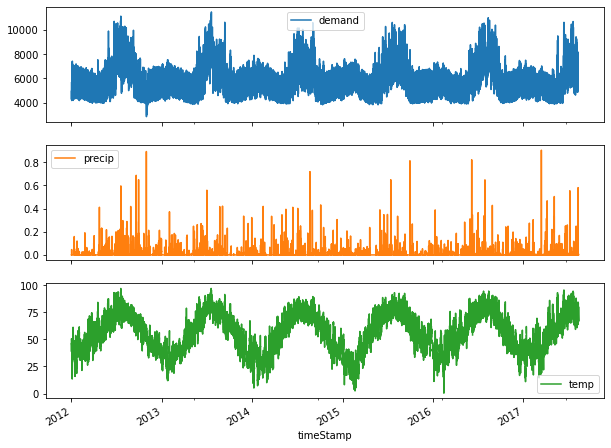

In [11]:
ny_df.plot(subplots=True)

**As temperature increses, the electricity demand also increases**

**As the data is hourly, we are converting to daily data by resampling**

In [12]:
ny_df.resample('D').mean()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500
...,...,...,...
2017-08-08,6471.626042,0.000000,71.039167
2017-08-09,6811.112167,0.047529,73.852500
2017-08-10,5582.297000,0.002033,75.217500


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f31e2afb150>,
      dtype=object)

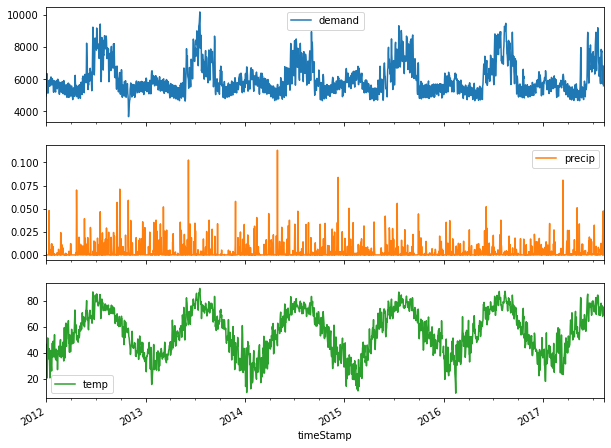

In [13]:
ny_df.resample('D').mean().plot(subplots=True)

In [14]:
df_daily=ny_df.resample('D').mean()

In [15]:
df_daily.head()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500


In [16]:
df_daily['demand']=df_daily['demand'].fillna(method='ffill')
df_daily['precip']=df_daily['precip'].fillna(method='ffill')
df_daily['temp']=df_daily['temp'].fillna(method='ffill')

In [17]:
from fbprophet import Prophet

In [18]:
df_final=df_daily.reset_index()[['timeStamp','demand']].rename({'timeStamp':'ds','demand':'y'},axis='columns')

In [19]:
df_final.head()

,ds,y
0,2012-01-01,4954.833333
1,2012-01-02,5302.954167
2,2012-01-03,6095.512500
3,2012-01-04,6336.266667
4,2012-01-05,6130.245833


**We renamed the timestamp and demand columns in order to feed to the prophet model**

In [20]:
train = df_final[(df_final['ds']>='2012-01-01') & (df_final['ds']<='2017-04-30')]
test = df_final[(df_final['ds']>'2017-04-30')]

In [21]:
train.shape

(1947, 2)

In [22]:
test.shape

(104, 2)

In [23]:
test.tail()

,ds,y
2046,2017-08-08,6471.626042
2047,2017-08-09,6811.112167
2048,2017-08-10,5582.297000
2049,2017-08-11,5582.297000
2050,2017-08-12,5582.297000


# Prophet model

In [24]:
model=Prophet(interval_width=0.95,yearly_seasonality=True)

**We gave the parameters: confidence interval = 95 % and there is seasonality in the data so True**

In [25]:
model.fit(train)

In [26]:
model.params

{'k': array([[0.08260908]]),
 'm': array([[0.5937986]]),
 'delta': array([[-3.50360674e-09, -1.32489168e-02, -7.74174578e-02,
          2.56670913e-08,  8.81258464e-08, -1.46805043e-08,
          1.70635442e-08, -2.64450633e-08, -5.82121639e-08,
          5.89599724e-08, -5.16647027e-02, -5.73312969e-02,
         -5.10303343e-05,  3.64173165e-08,  2.05843529e-01,
          5.29272199e-02, -1.73045352e-07, -8.36841050e-02,
         -7.56589140e-02,  3.12992747e-08, -2.32275699e-08,
          1.07689546e-08,  2.03120136e-02,  2.96291061e-03,
          2.74957150e-08]]),
 'sigma_obs': array([[0.04598355]]),
 'beta': array([[-0.03474564, -0.07051982,  0.05760445,  0.04706222, -0.01404777,
         -0.00499591, -0.00387932, -0.00073284,  0.00241073, -0.00756147,
          0.00404936,  0.00483016, -0.00789882, -0.00470511,  0.00701484,
         -0.00268429, -0.00128001,  0.00170179,  0.00035188, -0.0002186 ,
         -0.02824661,  0.02385118,  0.0206227 ,  0.00054777, -0.00494972,
         -

In [27]:
future=model.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [28]:
forecast=model.predict(future)

In [29]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,6034.940960,4209.738884,6071.283676,6034.940960,6034.940960,-929.934617,-929.934617,-929.934617,-541.068072,-541.068072,-541.068072,-388.866544,-388.866544,-388.866544,0.0,0.0,0.0,5105.006343
1,2012-01-02,6035.372399,4918.352439,6659.381167,6035.372399,6035.372399,-245.909743,-245.909743,-245.909743,133.872072,133.872072,133.872072,-379.781815,-379.781815,-379.781815,0.0,0.0,0.0,5789.462656
2,2012-01-03,6035.803837,4970.184034,6909.532679,6035.803837,6035.803837,-129.225376,-129.225376,-129.225376,240.783556,240.783556,240.783556,-370.008933,-370.008933,-370.008933,0.0,0.0,0.0,5906.578461
3,2012-01-04,6036.235275,5017.263873,6826.444445,6036.235275,6036.235275,-121.910180,-121.910180,-121.910180,237.713222,237.713222,237.713222,-359.623402,-359.623402,-359.623402,0.0,0.0,0.0,5914.325096
4,2012-01-05,6036.666714,4950.770372,6768.055505,6036.666714,6036.666714,-151.658496,-151.658496,-151.658496,197.050426,197.050426,197.050426,-348.708921,-348.708921,-348.708921,0.0,0.0,0.0,5885.008218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,2017-08-08,6090.176660,6704.888782,8503.761987,6063.897168,6119.245835,1502.790656,1502.790656,1502.790656,240.783556,240.783556,240.783556,1262.007099,1262.007099,1262.007099,0.0,0.0,0.0,7592.967315
2047,2017-08-09,6090.205898,6696.533990,8464.378009,6063.542809,6119.606788,1491.920917,1491.920917,1491.920917,237.713222,237.713222,237.713222,1254.207695,1254.207695,1254.207695,0.0,0.0,0.0,7582.126815
2048,2017-08-10,6090.235136,6650.395324,8481.684209,6063.188451,6119.966540,1446.655912,1446.655912,1446.655912,197.050426,197.050426,197.050426,1249.605487,1249.605487,1249.605487,0.0,0.0,0.0,7536.891048
2049,2017-08-11,6090.264374,6531.802091,8432.577411,6062.834778,6120.326292,1401.891046,1401.891046,1401.891046,153.844819,153.844819,153.844819,1248.046226,1248.046226,1248.046226,0.0,0.0,0.0,7492.155420


In [30]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7592.967315,6704.888782,8503.761987
2047,2017-08-09,7582.126815,6696.533990,8464.378009
2048,2017-08-10,7536.891048,6650.395324,8481.684209
2049,2017-08-11,7492.155420,6531.802091,8432.577411
2050,2017-08-12,6917.407396,5984.074826,7889.737157


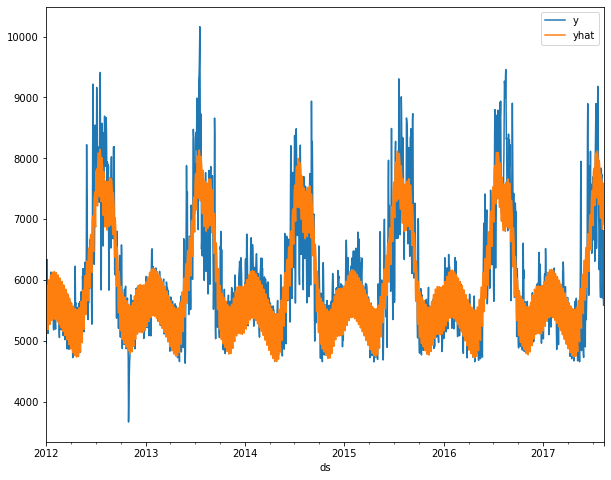

In [31]:
pd.concat([df_final.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

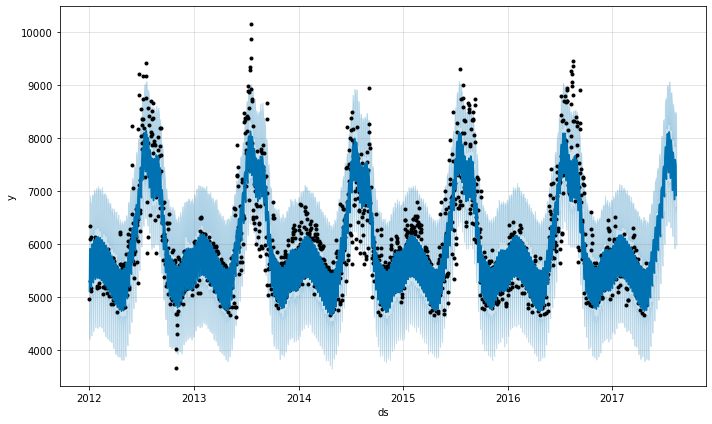

In [32]:
fig=model.plot(forecast)

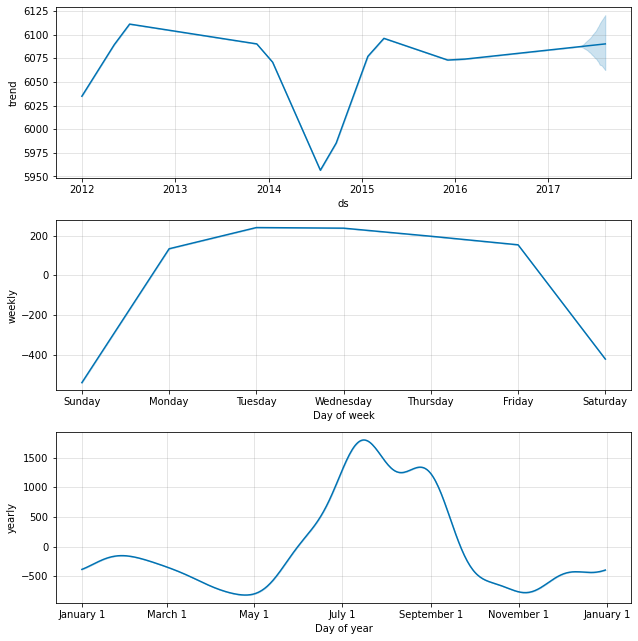

In [33]:
fig2=model.plot_components(forecast)

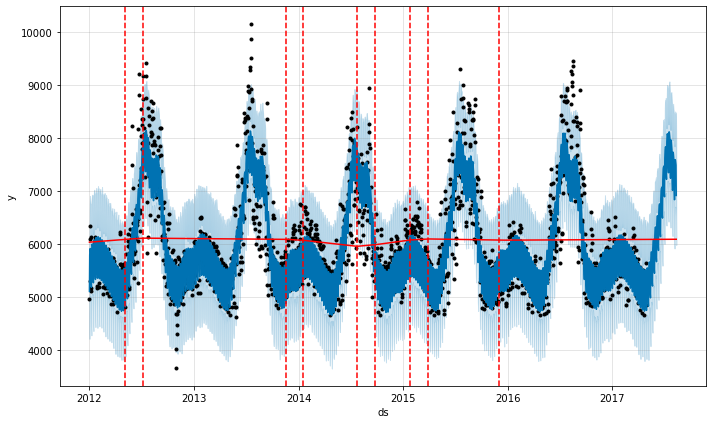

In [34]:
from fbprophet.plot import add_changepoints_to_plot
fig=model.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),model,forecast)

In [35]:
deltas=model.params['delta'].mean(0)
deltas

array([-3.50360674e-09, -1.32489168e-02, -7.74174578e-02,  2.56670913e-08,
        8.81258464e-08, -1.46805043e-08,  1.70635442e-08, -2.64450633e-08,
       -5.82121639e-08,  5.89599724e-08, -5.16647027e-02, -5.73312969e-02,
       -5.10303343e-05,  3.64173165e-08,  2.05843529e-01,  5.29272199e-02,
       -1.73045352e-07, -8.36841050e-02, -7.56589140e-02,  3.12992747e-08,
       -2.32275699e-08,  1.07689546e-08,  2.03120136e-02,  2.96291061e-03,
        2.74957150e-08])

In [36]:
len(deltas)

25

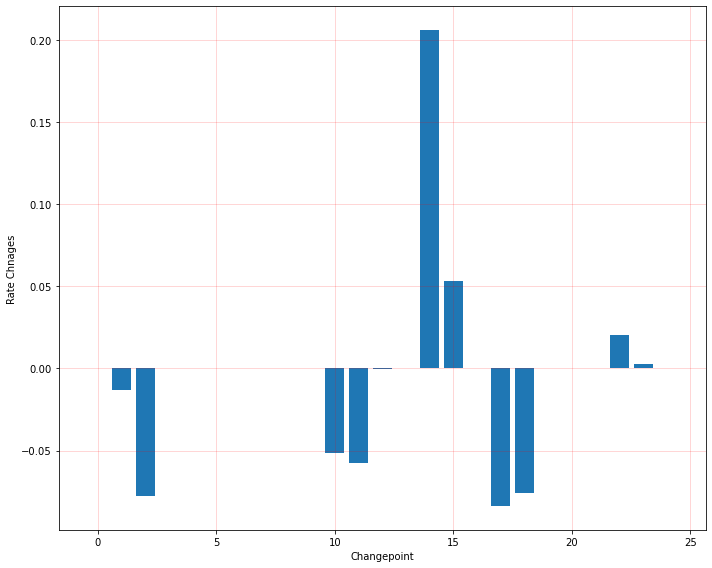

In [37]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)),deltas)
ax.grid(True,which='major',c='red',ls='-',alpha=0.2)
ax.set_ylabel('Rate Chnages')
ax.set_xlabel('Changepoint')
fig.tight_layout()

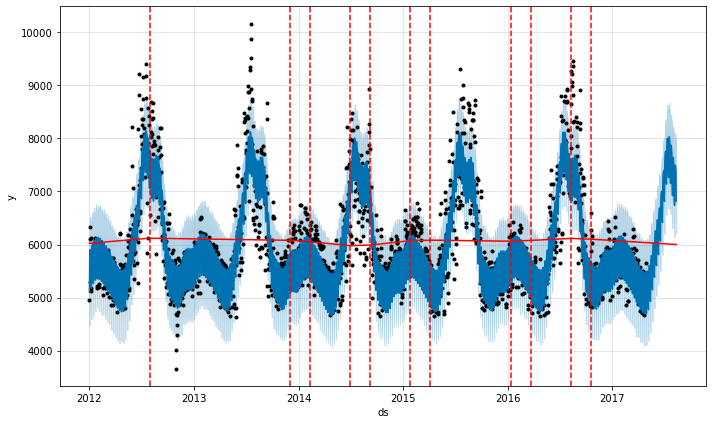

In [38]:
pro_change = Prophet(changepoint_range=0.9,yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),pro_change,forecast)

In [39]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(model,forecast) 
py.iplot(fig)

In [40]:
from fbprophet.diagnostics import cross_validation
cv_results = cross_validation(model = model,initial = '731 days',horizon='365 days')

In [41]:

cv_results.head(5)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-02,5562.299764,4695.280564,6407.561564,5460.325000,2014-05-01
1,2014-05-03,4972.355598,4080.589010,5861.952626,4893.683333,2014-05-01
2,2014-05-04,4848.530878,4085.168347,5700.843773,4764.137500,2014-05-01
3,2014-05-05,5529.479383,4706.835648,6351.704162,5406.762500,2014-05-01
4,2014-05-06,5624.452824,4817.889804,6416.354871,5409.750000,2014-05-01


In [42]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,253323.890470,503.312915,407.780697,0.073314,0.065546,0.890110
1,37 days 00:00:00,260083.383209,509.983709,415.161223,0.074599,0.066415,0.884615
2,37 days 12:00:00,262430.427705,512.279638,418.571701,0.075186,0.067624,0.884615
3,38 days 00:00:00,265227.392660,515.002323,421.686799,0.075451,0.068394,0.884615
4,38 days 12:00:00,268970.688046,518.623841,426.940376,0.076290,0.068828,0.884615
...,...,...,...,...,...,...,...
653,363 days 00:00:00,264075.407243,513.882678,450.853098,0.083226,0.082754,0.983516
654,363 days 12:00:00,265804.003277,515.561833,451.938016,0.083418,0.083504,0.978022
655,364 days 00:00:00,270233.232488,519.839622,455.544228,0.084268,0.084394,0.972527
656,364 days 12:00:00,270297.998974,519.901913,455.257718,0.084253,0.084394,0.972527
